# Loading Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(12, 5)},
        font_scale=1.5,
        style="whitegrid")
        
from pyspark.sql import HiveContext
from pyspark.sql import SQLContext

# initialize session hive and sql environments
hiveContext = HiveContext(sc)
sqlContext = SQLContext(sc)

# Data Reading

In [3]:
project_folder = "../"
datapath = project_folder + "data/"
plotpath = project_folder + "graphs/"
mungepath = project_folder + "munge/"
configpath = project_folder + "config/"
diagnostic = project_folder + "diagnostic/"
modelpath = project_folder + "model/"
output = project_folder + "output/"

In [4]:
from pyspark.sql.functions import col

train = spark.read.csv(os.path.join(datapath,"train.csv"), header=True)
print('Found %d observations in training set.' %train.count())

Found 184903890 observations in training set.


In [5]:
from pyspark.sql.functions import col

test_old = (spark.read.csv(os.path.join(datapath,"test_supplement.csv"), header=True)
            .filter(col('click_time') >= '2017-11-09 16:00:00'))

print('Found %d observations in test_old set.' %test_old.count())

Found 57536872 observations in test_old set.


In [6]:
train.show(10)

+------+---+------+---+-------+-------------------+---------------+-------------+
|    ip|app|device| os|channel|         click_time|attributed_time|is_attributed|
+------+---+------+---+-------+-------------------+---------------+-------------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21|           null|            0|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34|           null|            0|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12|           null|            0|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52|           null|            0|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08|           null|            0|
| 18787|  3|     1| 16|    379|2017-11-06 14:36:26|           null|            0|
|103022|  3|     1| 23|    379|2017-11-06 14:37:44|           null|            0|
|114221|  3|     1| 19|    379|2017-11-06 14:37:59|           null|            0|
|165970|  3|     1| 13|    379|2017-11-06 14:38:10|           null|            0|
| 74544| 64|    

In [7]:
train.printSchema()

root
 |-- ip: string (nullable = true)
 |-- app: string (nullable = true)
 |-- device: string (nullable = true)
 |-- os: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- click_time: string (nullable = true)
 |-- attributed_time: string (nullable = true)
 |-- is_attributed: string (nullable = true)



# Build the full dataset

In [8]:
# train and test set concatenation
from pyspark.sql.functions import col
data = (train.select('ip', 'app', 'device', 'os', 'channel', 'click_time')
        .unionAll(test_old.select('ip', 'app', 'device', 'os', 'channel', 'click_time')))
        
print('Total number of clicks in one week:', data.count())

Total number of clicks in one week: 242440762


In [9]:
data.show(5)

+------+---+------+---+-------+-------------------+
|    ip|app|device| os|channel|         click_time|
+------+---+------+---+-------+-------------------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08|
+------+---+------+---+-------+-------------------+
only showing top 5 rows



# Datetime Features

In [10]:
# day function
def get_day(date):
    """
    Returns the hour based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        day: A String containing the day of click ("06", "07", .."10")
    """
    
    return date[8:10]

# hour function
def get_hour(date):
    """
    Returns the hour based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        hour: A String containing the hour interval ("01", "02", .."23")
    """
    
    return date[11:13]

# minute function
def get_minute(date):
    """
    Returns the minute based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        hour: A String containing the minute interval ("01", "02", .."59")
    """
    
    return date[14:16]

In [11]:
# Get datetime features
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

day_udf = udf(get_day, StringType())
hour_udf = udf(get_hour, StringType())
minute_udf = udf(get_minute, StringType())

data = data.withColumn('day', day_udf(data.click_time))
data = data.withColumn('hour', hour_udf(data.click_time))
data = data.withColumn('minute', minute_udf(data.click_time))

In [12]:
data.show(5)

+------+---+------+---+-------+-------------------+---+----+------+
|    ip|app|device| os|channel|         click_time|day|hour|minute|
+------+---+------+---+-------+-------------------+---+----+------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21| 06|  14|    32|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34| 06|  14|    33|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12| 06|  14|    34|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52| 06|  14|    34|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08| 06|  14|    35|
+------+---+------+---+-------+-------------------+---+----+------+
only showing top 5 rows



# IP Number of Clicks for same App

In [15]:
from pyspark.sql.functions import col, unix_timestamp, lit
import pyspark.sql.functions as func

In [13]:
var = 'app'

In [16]:
train.groupBy().agg(func.min('click_time')).show()

+-------------------+
|    min(click_time)|
+-------------------+
|2017-11-06 14:32:21|
+-------------------+



In [17]:
ip_var_clicks = (data
                 .withColumn('click_time_seconds',
                             (unix_timestamp(col('click_time')) - unix_timestamp(lit('2017-11-06 14:32:21'))))
                 .groupBy('ip', var)
                 .agg(func.count(func.lit(1)).alias('ip_'+var+'_clicks'),
                      func.round(func.stddev(col('click_time_seconds'))).alias('ip_'+var+'_std_click_time'),
                      func.round(func.stddev(col('hour')), 2).alias('ip_'+var+'_std_hour'),
                      func.round(func.stddev(col('minute')), 2).alias('ip_'+var+'_std_minute'),
                      func.round(func.mean(col('hour')), 2).alias('ip_'+var+'_avg_hour'),
                      func.round(func.mean(col('minute')), 2).alias('ip_'+var+'_avg_minute'))
                 .fillna({'ip_'+var+'_std_click_time':0,
                          'ip_'+var+'_std_hour':0,
                          'ip_'+var+'_std_minute':0,
                          'ip_'+var+'_avg_hour':0,
                          'ip_'+var+'_avg_minute':0})
                 .cache())

ip_var_clicks.show(100, truncate=False)

+------+---+-------------+---------------------+---------------+-----------------+---------------+-----------------+
|ip    |app|ip_app_clicks|ip_app_std_click_time|ip_app_std_hour|ip_app_std_minute|ip_app_avg_hour|ip_app_avg_minute|
+------+---+-------------+---------------------+---------------+-----------------+---------------+-----------------+
|105388|64 |45           |60882.0              |6.34           |17.09            |9.29           |32.44            |
|4779  |15 |426          |97481.0              |6.45           |16.04            |11.01          |27.77            |
|124317|14 |544          |102105.0             |6.75           |17.29            |8.59           |28.58            |
|25648 |2  |34617        |96440.0              |6.12           |17.29            |11.39          |29.85            |
|105560|2  |29658        |81014.0              |6.36           |17.39            |10.92          |29.5             |
|56593 |2  |481          |96667.0              |5.5            |

In [18]:
data.filter((col('ip')==160143) & (col(var)==26)).show(truncate=False)

+------+---+------+---+-------+-------------------+---+----+------+
|ip    |app|device|os |channel|click_time         |day|hour|minute|
+------+---+------+---+-------+-------------------+---+----+------+
|160143|26 |1     |6  |266    |2017-11-06 22:46:44|06 |22  |46    |
|160143|26 |1     |27 |121    |2017-11-07 05:12:36|07 |05  |12    |
|160143|26 |1     |13 |266    |2017-11-07 11:47:07|07 |11  |47    |
+------+---+------+---+-------+-------------------+---+----+------+



## Export New Features

In [19]:
(ip_var_clicks
 .coalesce(1)
 .write
 .format("com.databricks.spark.csv")
 .option("header", "true")
 .mode("overwrite")
 .save(mungepath+"f_ip_"+var+"_clicks", compression="None"))

In [20]:
ip_var_clicks.count()

4533337

## Check the impact of new features

In [21]:
import pyspark.sql.functions as func

train.groupBy().agg(func.mean(col('is_attributed'))).show()

+--------------------+
|  avg(is_attributed)|
+--------------------+
|0.002470721410998979|
+--------------------+



In [23]:
train_sample = (train.sample(fraction=0.05, withReplacement=False, seed=22)
                .join(ip_var_clicks, ['ip', var], 'left_outer')
                .cache())

In [24]:
train_sample.count()

9248009

In [25]:
train.sample(fraction=0.05, withReplacement=False, seed=22).count()

9248009

In [26]:
train_sample.show(5, truncate=False)

+------+---+------+---+-------+-------------------+---------------+-------------+-------------+---------------------+---------------+-----------------+---------------+-----------------+
|ip    |app|device|os |channel|click_time         |attributed_time|is_attributed|ip_app_clicks|ip_app_std_click_time|ip_app_std_hour|ip_app_std_minute|ip_app_avg_hour|ip_app_avg_minute|
+------+---+------+---+-------+-------------------+---------------+-------------+-------------+---------------------+---------------+-----------------+---------------+-----------------+
|100032|13 |1     |36 |477    |2017-11-08 11:08:54|null           |0            |51           |117880.0             |5.97           |18.11            |9.92           |26.65            |
|100054|22 |1     |22 |116    |2017-11-08 23:57:38|null           |0            |34           |118525.0             |5.51           |17.97            |9.56           |28.74            |
|100054|22 |1     |6  |116    |2017-11-07 05:54:18|null           |0  

### ip_app_clicks

In [30]:
feature = 'ip_app_clicks'

In [31]:
PDF = train_sample.select('is_attributed', feature).toPandas()

In [32]:
PDF.head()

,is_attributed,ip_app_clicks
0,0,51
1,0,34
2,0,34
3,0,1129
4,0,1129


In [33]:
PDF_sorted = PDF.sort_values(by=feature)

In [34]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [35]:
PDF_sorted.head()

,is_attributed,ip_app_clicks,roll
9248008,0,1,NaN
8256194,0,1,NaN
2678102,0,1,NaN
2678111,0,1,NaN
806203,1,1,NaN


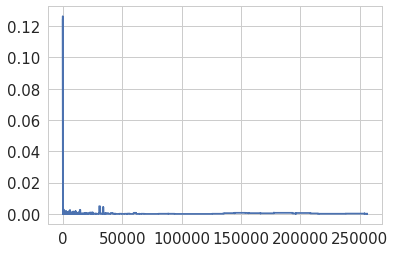

In [36]:
plt.plot(PDF_sorted[feature], PDF_sorted.roll)

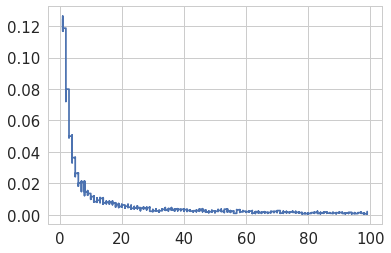

In [37]:
PDF_filtered = PDF_sorted[PDF_sorted[feature]<100]

plt.plot(PDF_filtered[feature], PDF_filtered.roll)

Very strong feature !

### ip_app_std_click_time

In [38]:
feature = 'ip_app_std_click_time'

In [39]:
PDF = train_sample.select('is_attributed', feature).toPandas()

In [40]:
PDF.head()

,is_attributed,ip_app_std_click_time
0,0,117880.0
1,0,118525.0
2,0,118525.0
3,0,102606.0
4,0,102606.0


In [41]:
PDF_sorted = PDF.sort_values(by=feature)

In [42]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [43]:
PDF_sorted.head()

,is_attributed,ip_app_std_click_time,roll
9248008,0,0.0,NaN
398175,0,0.0,NaN
398165,1,0.0,NaN
4922956,1,0.0,NaN
398038,0,0.0,NaN


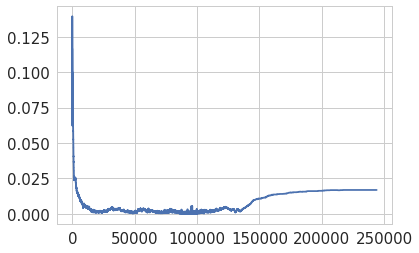

In [44]:
plt.plot(PDF_sorted[feature], PDF_sorted.roll)

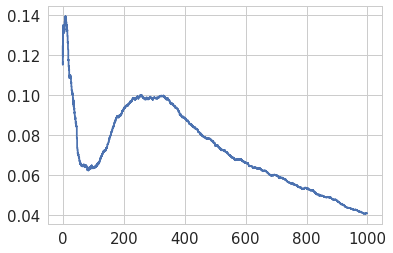

In [45]:
PDF_filtered = PDF_sorted[PDF_sorted[feature]<1000]

plt.plot(PDF_filtered[feature], PDF_filtered.roll)

Very strong feature !

### ip_app_std_hour

In [46]:
feature = 'ip_app_std_hour'

In [47]:
PDF = train_sample.select('is_attributed', feature).toPandas()

In [48]:
PDF.head()

,is_attributed,ip_app_std_hour
0,0,5.97
1,0,5.51
2,0,5.51
3,0,6.61
4,0,6.61


In [49]:
PDF_sorted = PDF.sort_values(by=feature)

In [50]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [51]:
PDF_sorted.head()

,is_attributed,ip_app_std_hour,roll
9248008,0,0.0,NaN
6092758,0,0.0,NaN
386162,0,0.0,NaN
6092865,0,0.0,NaN
6092893,0,0.0,NaN


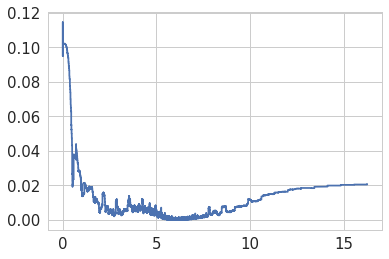

In [52]:
plt.plot(PDF_sorted[feature], PDF_sorted.roll)

Very strong feature !

### ip_app_std_minute

In [53]:
feature = 'ip_app_std_minute'

In [54]:
PDF = train_sample.select('is_attributed', feature).toPandas()

In [55]:
PDF.head()

,is_attributed,ip_app_std_minute
0,0,18.11
1,0,17.97
2,0,17.97
3,0,17.31
4,0,17.31


In [56]:
PDF_sorted = PDF.sort_values(by=feature)

In [57]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [58]:
PDF_sorted.head()

,is_attributed,ip_app_std_minute,roll
9248008,0,0.0,NaN
2150206,0,0.0,NaN
5782567,0,0.0,NaN
5782482,0,0.0,NaN
3271876,0,0.0,NaN


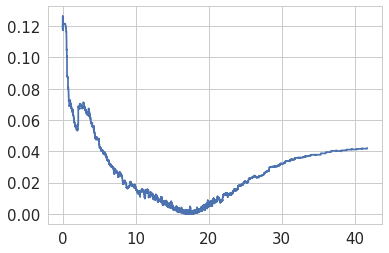

In [60]:
plt.plot(PDF_sorted[feature], PDF_sorted.roll)

Very strong feature !

### ip_app_avg_hour

In [61]:
feature = 'ip_app_avg_hour'

In [62]:
PDF = train_sample.select('is_attributed', feature).toPandas()

In [63]:
PDF.head()

,is_attributed,ip_app_avg_hour
0,0,9.92
1,0,9.56
2,0,9.56
3,0,9.21
4,0,9.21


In [64]:
PDF_sorted = PDF.sort_values(by=feature)

In [65]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [66]:
PDF_sorted.head()

,is_attributed,ip_app_avg_hour,roll
350477,0,0.0,NaN
4746128,0,0.0,NaN
5030203,0,0.0,NaN
1610622,0,0.0,NaN
5995093,0,0.0,NaN


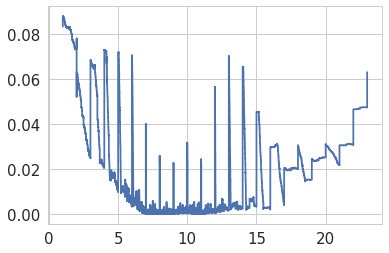

In [67]:
plt.plot(PDF_sorted[feature], PDF_sorted.roll)

Very interesting feature !  
It looks like ip addresses that use same app in average between 5 and 15 download much less.

### ip_app_avg_minute

In [68]:
feature = 'ip_app_avg_minute'

In [69]:
PDF = train_sample.select('is_attributed', feature).toPandas()

In [70]:
PDF.head()

,is_attributed,ip_app_avg_minute
0,0,26.65
1,0,28.74
2,0,28.74
3,0,29.12
4,0,29.12


In [71]:
PDF_sorted = PDF.sort_values(by=feature)

In [72]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [73]:
PDF_sorted.head()

,is_attributed,ip_app_avg_minute,roll
9113080,0,0.0,NaN
2102979,0,0.0,NaN
2767495,0,0.0,NaN
6493850,0,0.0,NaN
5853521,0,0.0,NaN


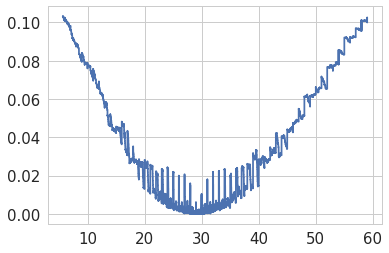

In [74]:
plt.plot(PDF_sorted[feature], PDF_sorted.roll)

Very strong feature !  
It looks like ip addresses that use same app in average at the half of a minute download much less.  